In [1]:
using CSV, DataFrames, Dates, Plots

## 1; Dados da pandemia de COVID-19 no Rio de Janeiro


- Os dados obtidos em [1] foram tratados no notebook  TratamentoDadosCovidRJ.ipynb .


- Após carregar os dados, precisamos selecionar um ou mais períodos para modelar.

[1] https://www.data.rio/datasets/PCRJ::cep-dos-casos-confirmados-de-covid-19-no-munic%C3%ADpio-do-rio-de-janeiro-1/about

In [2]:
df = DataFrame(CSV.File("DadosMedia.csv"))

datasTudo = df[:,"DatasMedia"]
infTudo = df[:,"InfectadosMedia"]
recTudo = df[:,"RecuperadosMedia"]
decTudo = df[:,"ObitosMedia"]

limiteE = findall(data->data==Date(2020,03,18),datasTudo)[1]
limiteD = findall(data->data==Date(2020,06,30),datasTudo)[1]

datasOnda = datasTudo[limiteE:limiteD]
infOnda = infTudo[limiteE:limiteD]
recOnda = recTudo[limiteE:limiteD]
decOnda = decTudo[limiteE:limiteD]

dadosOnda = hcat(infOnda,recOnda,decOnda)

nothing

In [3]:
#susIniciais = 6_748_000. # ~ População total da cidade do Rio de Janeiro
susIniciais = 50_000.

u₀_dados = [infOnda[1],recOnda[1],decOnda[1]]
θ₀_SIRD = [0.5, 0.5, 0.5] # ...?

nothing

## 2; Ajustando uma *Neural Ordinary Differential Equation*

In [4]:
using DiffEqFlux, DifferentialEquations.OrdinaryDiffEq, Optim, Random; include("AuxMisc.jl")

### 2.1; Ajuste para dados dos $N$ primeiros dias

- Vamos ajustar os parâmetros do modelo *UODE* utilizando somente os dados dos $N$ primeiros dias para testar sua capacidade de previsão.

In [5]:
function dudtSIRD!(du, u, θ, t)
    S, I, R, D = u
    β, γ_R, γ_D = θ

    E_novos = β^2*I*S/(S+I+R+D)
    dS = -E_novos 
    dI = E_novos - (γ_R^2 + γ_D^2)*I
    dR = γ_R^2*I
    dD = γ_D^2*I

    du[1] = dS; du[2] = dI; du[3] = dR; du[4] = dD
end

function dudtSIRD(u, θ)
    S, I, R, D = u
    β, γ_R, γ_D  = θ

    E_novos = β^2*I*S/(S+I+R+D)
    dS = -E_novos 
    dI = E_novos - (γ_R^2 + γ_D^2)*I
    dR = γ_R^2*I
    dD = γ_D^2*I

    return [dS, dI, dR, dD]
end

function dudtNODE!(du, u, θ, t, NN)
    S, I, R, D = u
    dS, dI, dR, dD = NN([S, I, R, D], θ)
    du[1] = dS; du[2] = dI; du[3] = dR; du[4] = dD
end

nothing

In [7]:
#NN = FastChain(FastDense(4,32,tanh), FastDense(32,32,tanh), FastDense(32,4), (X, p) -> [-X[1]^2, X[2], X[3]^2, X[4]^2])
NN = FastChain(FastDense(4,32,tanh), FastDense(32,32,tanh), FastDense(32,3), (X, p) -> [X[1]^2, X[2]^2, X[3]^2],
    (X, p) -> [-X[1], X[1]-X[2]-X[3], X[2], X[3]])

function treinarPorN_dias(N; NN = NN, dadosOnda = dadosOnda, u₀_dados = u₀_dados, θ₀_SIRD = θ₀_SIRD,
        tipoCusto = "inf_rec_dec", iterSIRD = 10^4, iterBFGS_NODE = 50)
    
    dadosTreino = dadosOnda[1:N, :]

    fatorReducao = maximum(dadosTreino)
    dadosTreino = dadosTreino ./ fatorReducao
    u₀_dados = u₀_dados ./ fatorReducao
    
    if tipoCusto == "inf_rec_dec"
        indModelo = [2, 3, 4]; indDados = [1, 2, 3]
    elseif tipoCusto == "dec"
        indModelo = [4]; indDados = [3]
    else 
        return "Tipo de custo não identificado"
    end
    
    dadosTreinoT = dadosTreino[:, indDados]'
    
    # AJUSTE SIRD:
    function modeloSIRD(θ_expandido)
        θ = θ_expandido[2:4]
        u₀ = [θ_expandido[1]; u₀_dados]
        solve(ODEProblem(dudtSIRD!, u₀, (1., N), θ), saveat = 1)[indModelo, :]
    end
    
    custo(θ) = sum(abs2, dadosTreinoT .- modeloSIRD(θ))
       
    result = Optim.minimizer(optimize(custo, [1.; θ₀_SIRD], iterations = iterSIRD))

    S₀_SIRD = result[1]    
    θ₁_SIRD = result[2:4]
    
    # INICIALIZANDO NN:
    println("Inicializando NN:")
    
    Xs = rand(4, 1_000)
    Xs .*= max(1., S₀_SIRD)
    
    dataSIRD = [dudtSIRD(X, θ₁_SIRD) for X in eachcol(Xs)]
    
    function costInitializeNN(θ)
        pred = [NN(X, θ) for X in eachcol(Xs)]
        return sum(abs2, mapreduce(permutedims, vcat, dataSIRD .- pred)), pred
    end

    costsInitializeNN = []

    function callBackInitializeNN(θ, cost, pred)
        push!(costsInitializeNN, cost)
        if length(costsInitializeNN) % 100 == 0
            println("Iteracao : ", length(costsInitializeNN), " , Erro : ", SciRound(cost))
        end
        false
    end
        
    resultInitializeNN = DiffEqFlux.sciml_train(costInitializeNN, initial_params(NN), cb = callBackInitializeNN,
        BFGS(initial_stepnorm = 0.01), maxiters = 1_000, allow_f_increases = true);
    
    θ₀_NN = resultInitializeNN.minimizer
    
    
    # AJUSTE NODE:
    println("Ajustando NODE:")
    
    dudtNODE_!(du, u, θ, t) = dudtNODE!(du, u, θ, t, NN)
    
    function modeloNODE(θ_expandido)
        θ = θ_expandido[2:end]
        u₀ = [θ_expandido[1]; u₀_dados] 
        solve(ODEProblem(dudtNODE_!, u₀, (1., N), θ), saveat = 1)[indModelo, :]
    end
    
    function costNODE(θ)
        pred = modeloNODE(θ)
        cost = sum(abs2, dadosTreinoT .- pred)
        return cost, pred
    end

    costsNODE = []
    
    function callBackNODE(θ, cost, pred)
        push!(costsNODE, cost)
        if length(costsNODE)%10 == 0
            println("Iteracao : ", length(costsNODE), " , Erro : ", SciRound(cost))
        end
        false
    end    
    
    resultNODE = DiffEqFlux.sciml_train(costNODE, [S₀_SIRD; θ₀_NN], cb = callBackNODE, BFGS(initial_stepnorm = 0.01),
        maxiters = iterBFGS_NODE, allow_f_increases = true)
    
    S₀_NODE = resultNODE[1]
    θ₁_NODE = resultNODE[2:end]
    
    S₀_SIRD * fatorReducao, θ₁_SIRD, S₀_NODE * fatorReducao, θ₁_NODE
end

treinarPorN_dias (generic function with 1 method)

In [67]:
function intervals(N, S₀_SIRD, θ₁_SIRD, S₀_NODE, θ₁_NODE; NN = NN, dadosOnda = dadosOnda, u₀_dados = u₀_dados)    
    fatorReducao = maximum(dadosOnda[1:N, :])
    
    u₀_dados = u₀_dados ./ fatorReducao
    S₀_SIRD = S₀_SIRD / fatorReducao
    S₀_NODE = S₀_NODE / fatorReducao

    dadosOndaT = dadosOnda' ./ fatorReducao
    
    diasTotais = size(dadosOndaT[1, :])[1]
    
    # INTERVALOS DE BOA PREVISÃO NODE:
    
    dudtNODE_!(du, u, θ, t) = dudtNODE!(du, u, θ, t, NN)
    modelNODE = solve(ODEProblem(dudtNODE_!, [S₀_NODE; u₀_dados], (1., diasTotais), θ₁_NODE), saveat = 1)[[2, 3, 4], :]
    
    intervalsAll = []
    
    for indVar in [1, 2, 3]
        intervals = []
        
        for tol in [0.01, 0.02, 0.05, 0.1, 0.2, 0.3] # ??
            currDay = N
            currRealValue = dadosOndaT[indVar, currDay]
            currModelValue = modelNODE[indVar, currDay]
            err = abs(currRealValue - currModelValue)
        
            while err <= (tol * currRealValue) && currDay <= diasTotais 
                currDay += 1
                currRealValue = dadosOndaT[indVar, currDay]
                currModelValue = modelNODE[indVar, currDay]
                err = abs(currRealValue - currModelValue)
            end
            
            intervals = append!(intervals, currDay - N)
        end
        intervalsAll = append!(intervalsAll, [intervals])
    end
    intervalsAll = hcat(intervalsAll[1], intervalsAll[2], intervalsAll[3])
    
    # INTERVALOS DE BOA PREVISÃO SIRD:
    
    modelSIRD = solve(ODEProblem(dudtSIRD!, [S₀_SIRD; u₀_dados], (1., diasTotais), θ₁_SIRD), saveat = 1)[[2, 3, 4], :]
    
    intervalsAllSIRD = []
    
    for indVar in [1, 2, 3]
        intervals = []
        
        for tol in [0.01, 0.02, 0.05, 0.1, 0.2, 0.3] # ??
            currDay = N
            currRealValue = dadosOndaT[indVar, currDay]
            currModelValue = modelSIRD[indVar, currDay]
            err = abs(currRealValue - currModelValue)
        
            while err <= (tol * currRealValue) && currDay <= diasTotais 
                currDay += 1
                currRealValue = dadosOndaT[indVar, currDay]
                currModelValue = modelSIRD[indVar, currDay]
                err = abs(currRealValue - currModelValue)
            end
            
            intervals = append!(intervals, currDay - N)
        end
        intervalsAllSIRD = append!(intervalsAllSIRD, [intervals])
    end
    intervalsAllSIRD = hcat(intervalsAllSIRD[1], intervalsAllSIRD[2], intervalsAllSIRD[3])
    
    intervalsAll, intervalsAllSIRD
end

intervals (generic function with 1 method)

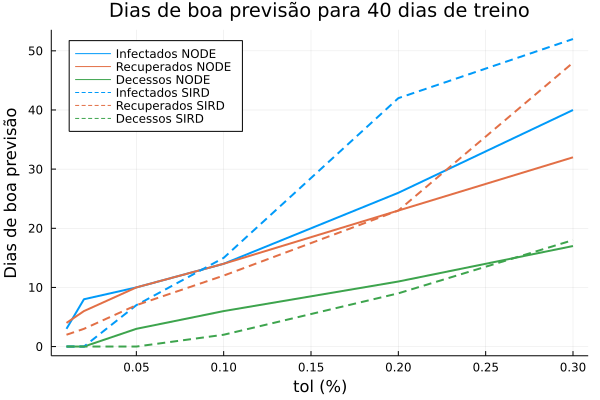

In [77]:
N = 40

boaPred, boaPredSIRD = intervals(N, S₀_SIRD, θ₁_SIRD, S₀_NODE, θ₁_NODE)

pl = plot([0.01, 0.02, 0.05, 0.1, 0.2, 0.3], boaPred[:, 1], lw = 2, color = 1, label = "Infectados NODE")
plot!(pl, [0.01, 0.02, 0.05, 0.1, 0.2, 0.3], boaPred[:, 2], lw = 2, color = 2, label = "Recuperados NODE")
plot!(pl, [0.01, 0.02, 0.05, 0.1, 0.2, 0.3], boaPred[:, 3], lw = 2, color = 3, label = "Decessos NODE")

#scatter!(pl, [0.01, 0.02, 0.05, 0.1, 0.2, 0.3], boaPred[:, 1], lw = 2, color = 1, label = "")
#scatter!(pl, [0.01, 0.02, 0.05, 0.1, 0.2, 0.3], boaPred[:, 2], lw = 2, color = 2, label = "")
#scatter!(pl, [0.01, 0.02, 0.05, 0.1, 0.2, 0.3], boaPred[:, 3], lw = 2, color = 3, label = "")

plot!(pl, [0.01, 0.02, 0.05, 0.1, 0.2, 0.3], boaPredSIRD[:, 1], lw = 2, linestyle = :dash, color = 1, label = "Infectados SIRD")
plot!(pl, [0.01, 0.02, 0.05, 0.1, 0.2, 0.3], boaPredSIRD[:, 2], lw = 2, linestyle = :dash, color = 2, label = "Recuperados SIRD")
plot!(pl, [0.01, 0.02, 0.05, 0.1, 0.2, 0.3], boaPredSIRD[:, 3], lw = 2, linestyle = :dash, color = 3, label = "Decessos SIRD")

#scatter!(pl, [0.01, 0.02, 0.05, 0.1, 0.2, 0.3], boaPredSIRD[:, 1], lw = 2, color = 1, label = "")
#scatter!(pl, [0.01, 0.02, 0.05, 0.1, 0.2, 0.3], boaPredSIRD[:, 2], lw = 2, color = 2, label = "")
#scatter!(pl, [0.01, 0.02, 0.05, 0.1, 0.2, 0.3], boaPredSIRD[:, 3], lw = 2, color = 3, label = "")

plot!(pl, title = "Dias de boa previsão para $N dias de treino", titlefont = 13, xlabel = "tol (%)", 
    ylabel = "Dias de boa previsão", legend = :topleft, legendfont = 8)

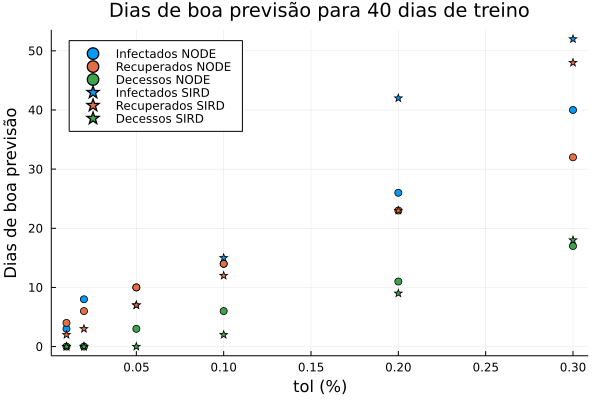

In [78]:
N = 40

boaPred, boaPredSIRD = intervals(N, S₀_SIRD, θ₁_SIRD, S₀_NODE, θ₁_NODE)

#pl = plot([0.01, 0.02, 0.05, 0.1, 0.2, 0.3], boaPred[:, 1], lw = 2, color = 1, label = "Infectados NODE")
#plot!(pl, [0.01, 0.02, 0.05, 0.1, 0.2, 0.3], boaPred[:, 2], lw = 2, color = 2, label = "Recuperados NODE")
#plot!(pl, [0.01, 0.02, 0.05, 0.1, 0.2, 0.3], boaPred[:, 3], lw = 2, color = 3, label = "Decessos NODE")

pl = scatter([0.01, 0.02, 0.05, 0.1, 0.2, 0.3], boaPred[:, 1], lw = 2, color = 1, label = "Infectados NODE")
scatter!(pl, [0.01, 0.02, 0.05, 0.1, 0.2, 0.3], boaPred[:, 2], lw = 2, color = 2, label = "Recuperados NODE")
scatter!(pl, [0.01, 0.02, 0.05, 0.1, 0.2, 0.3], boaPred[:, 3], lw = 2, color = 3, label = "Decessos NODE")

#plot!(pl, [0.01, 0.02, 0.05, 0.1, 0.2, 0.3], boaPredSIRD[:, 1], lw = 2, linestyle = :dash, color = 1, label = "Infectados SIRD")
#plot!(pl, [0.01, 0.02, 0.05, 0.1, 0.2, 0.3], boaPredSIRD[:, 2], lw = 2, linestyle = :dash, color = 2, label = "Recuperados SIRD")
#plot!(pl, [0.01, 0.02, 0.05, 0.1, 0.2, 0.3], boaPredSIRD[:, 3], lw = 2, linestyle = :dash, color = 3, label = "Decessos SIRD")

scatter!(pl, [0.01, 0.02, 0.05, 0.1, 0.2, 0.3], boaPredSIRD[:, 1], lw = 2, color = 1, markershape = :star5, label = "Infectados SIRD")
scatter!(pl, [0.01, 0.02, 0.05, 0.1, 0.2, 0.3], boaPredSIRD[:, 2], lw = 2, color = 2, markershape = :star5, label = "Recuperados SIRD")
scatter!(pl, [0.01, 0.02, 0.05, 0.1, 0.2, 0.3], boaPredSIRD[:, 3], lw = 2, color = 3, markershape = :star5, label = "Decessos SIRD")

plot!(pl, title = "Dias de boa previsão para $N dias de treino", titlefont = 13, xlabel = "tol (%)", 
    ylabel = "Dias de boa previsão", legend = :topleft, legendfont = 8)

In [14]:
function grafico(N, S₀_SIRD, θ₁_SIRD, S₀_NODE, θ₁_NODE; NN = NN, dadosOnda = dadosOnda, u₀_dados = u₀_dados)
    fatorReducao = maximum(dadosOnda[1:N, :])
    u₀_dados = u₀_dados ./ fatorReducao
    S₀_SIRD = S₀_SIRD / fatorReducao
    S₀_NODE = S₀_NODE / fatorReducao

    modeloSIRD = solve(ODEProblem(dudtSIRD!, [S₀_SIRD; u₀_dados], (1., size(dadosOnda)[1]), θ₁_SIRD), saveat = 1) .* fatorReducao

    infSIRD = modeloSIRD[2, :]
    recSIRD = modeloSIRD[3, :]
    decSIRD = modeloSIRD[4, :]
    
    dudtNODE_!(du, u, θ, t) = dudtNODE!(du, u, θ, t, NN)
    modeloNODE = solve(ODEProblem(dudtNODE_!, [S₀_NODE; u₀_dados], (1., size(dadosOnda)[1]), θ₁_NODE), saveat = 1)[[2, 3, 4], :]' .* fatorReducao
    
    infNODE = modeloNODE[:, 1]
    recNODE = modeloNODE[:, 2]
    decNODE = modeloNODE[:, 3]
    
    pl = plot(infOnda, label = "Infectados (dados)", lw = 2, color = 1)
    plot!(pl, infSIRD, label = "Infectados SIRD", lw = 2, linestyle = :dot, color = 1)
    plot!(pl, infNODE, label = "Infectados NODE", lw = 2, linestyle = :dash, color = 1)
    
    plot!(pl, recOnda, label = "Recuperados (dados)", lw = 2, color = 2)
    plot!(pl, recSIRD, label = "Recuperados SIRD", lw = 2, linestyle = :dot, color = 2)
    plot!(pl, recNODE, label = "Recuperados NODE", lw = 2, linestyle = :dash, color = 2)
    
    plot!(pl, decOnda, label = "Decessos (dados)", lw = 2, color = 3)
    plot!(pl, decSIRD, label = "Decessos SIRD", lw = 2, linestyle = :dot, color = 3)
    plot!(pl, decNODE, label = "Decessos NODE", lw = 2, linestyle = :dash, color = 3)
    
    plot!(pl, [N], seriestype = "vline", label = "Último dia do ajuste", color = "red")
    
    plot!(pl, title = "SIRD x NODE para $N dias de treino", titlefont = 11 , ylim = (-500, 30000),
        xlabel = "Dias percorridos", ylabel = "Total de indivíduos", legend = :topleft, legendfont = 6)
    
    pl
end

grafico (generic function with 1 method)

In [8]:
S₀_SIRD, θ₁_SIRD, S₀_NODE, θ₁_NODE = treinarPorN_dias(40, iterSIRD = 10^5, iterBFGS_NODE = 150)

Inicializando NN:
Iteracao : 100 , Erro : 6.62e-2
Iteracao : 200 , Erro : 1.50e-2
Iteracao : 300 , Erro : 4.98e-3
Iteracao : 400 , Erro : 2.61e-3
Iteracao : 500 , Erro : 1.65e-3
Iteracao : 600 , Erro : 1.12e-3
Iteracao : 700 , Erro : 9.00e-4
Iteracao : 800 , Erro : 6.60e-4
Iteracao : 900 , Erro : 5.66e-4
Iteracao : 1000 , Erro : 5.00e-4
Ajustando NODE:
Iteracao : 10 , Erro : 1.42e-2


Iteracao : 20 , Erro : 1.00e-2
Iteracao : 30 , Erro : 4.40e-3
Iteracao : 40 , Erro : 2.40e-3
Iteracao : 50 , Erro : 1.86e-3
Iteracao : 60 , Erro : 1.66e-3
Iteracao : 70 , Erro : 1.42e-3
Iteracao : 80 , Erro : 1.30e-3
Iteracao : 90 , Erro : 1.24e-3
Iteracao : 100 , Erro : 1.23e-3
Iteracao : 110 , Erro : 1.22e-3
Iteracao : 120 , Erro : 1.10e-3
Iteracao : 130 , Erro : 1.03e-3
Iteracao : 140 , Erro : 9.84e-4
Iteracao : 150 , Erro : 9.66e-4


(40885.12592935825, [0.37683834452506304, 0.18319189638286945, -0.06600215863291477], 40757.77949936693, [0.41860772463036233, -0.23059638447364755, 0.11558597643517197, 0.19064262593416975, 0.06283804191537534, 0.19366317051459, 0.16768029415610347, 0.14099199710900187, -0.06800901441412367, -0.19867821867227095  …  -0.20461630373815456, -0.3949611796595974, 0.09882000199623273, -0.0741901954375084, -0.4895601987391076, -0.115732632508364, -0.2379194897463067, 0.26676093065775414, -0.052913028884407104, -0.013374095791862696])

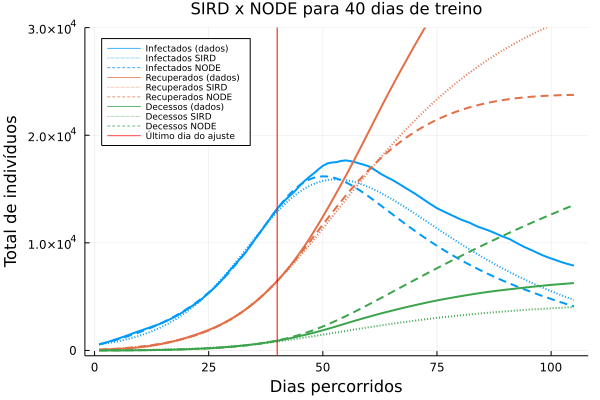

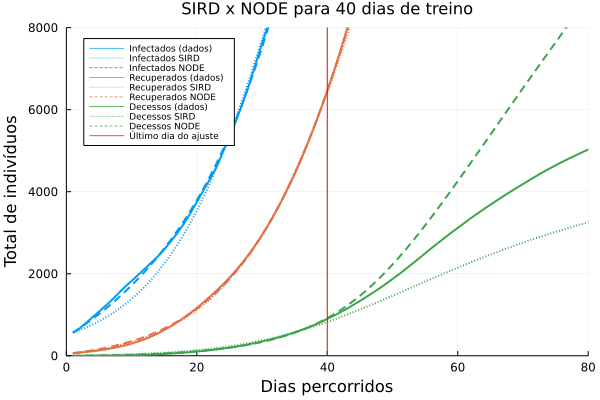

In [48]:
pl = grafico(40, S₀_SIRD, θ₁_SIRD, S₀_NODE, θ₁_NODE); display(pl)

plot!(pl, xlim = (0, 80), ylim = (0, 8_000)); display(pl)

Inicializando NN:
Iteracao : 100 , Erro : 4.57e-2
Iteracao : 200 , Erro : 1.45e-2
Iteracao : 300 , Erro : 8.60e-3
Iteracao : 400 , Erro : 5.21e-3
Iteracao : 500 , Erro : 2.60e-3
Iteracao : 600 , Erro : 1.71e-3
Iteracao : 700 , Erro : 1.24e-3
Iteracao : 800 , Erro : 1.06e-3
Iteracao : 900 , Erro : 9.51e-4
Iteracao : 1000 , Erro : 8.25e-4
Ajustando NODE:
Iteracao : 10 , Erro : 1.04e-2
Iteracao : 20 , Erro : 7.11e-3
Iteracao : 30 , Erro : 5.69e-3
Iteracao : 40 , Erro : 2.44e-3
Iteracao : 50 , Erro : 7.17e-4
Iteracao : 60 , Erro : 4.41e-4
Iteracao : 70 , Erro : 3.88e-4
Iteracao : 80 , Erro : 3.64e-4
Iteracao : 90 , Erro : 3.53e-4
Iteracao : 100 , Erro : 3.49e-4
Iteracao : 110 , Erro : 3.49e-4
Iteracao : 120 , Erro : 3.44e-4
Iteracao : 130 , Erro : 3.18e-4
Iteracao : 140 , Erro : 2.97e-4


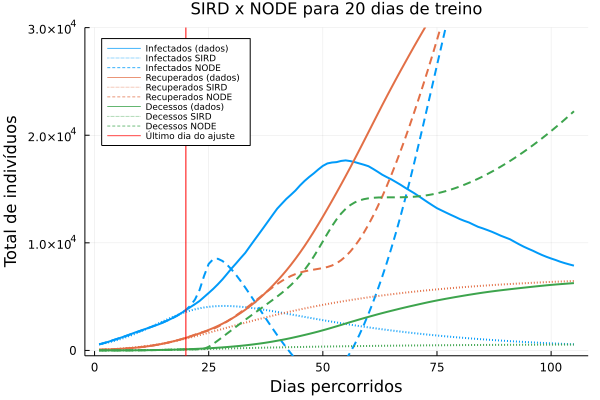

Iteracao : 150 , Erro : 2.96e-4
Inicializando NN:
Iteracao : 100 , Erro : 7.72e-2
Iteracao : 200 , Erro : 3.75e-2
Iteracao : 300 , Erro : 1.68e-2
Iteracao : 400 , Erro : 7.54e-3
Iteracao : 500 , Erro : 4.06e-3
Iteracao : 600 , Erro : 2.78e-3
Iteracao : 700 , Erro : 2.20e-3
Iteracao : 800 , Erro : 1.67e-3
Iteracao : 900 , Erro : 1.42e-3
Iteracao : 1000 , Erro : 1.26e-3
Ajustando NODE:
Iteracao : 10 , Erro : 1.36e-2
Iteracao : 20 , Erro : 8.92e-3
Iteracao : 30 , Erro : 5.62e-3
Iteracao : 40 , Erro : 1.31e-3
Iteracao : 50 , Erro : 1.15e-3
Iteracao : 60 , Erro : 9.91e-4
Iteracao : 70 , Erro : 8.19e-4
Iteracao : 80 , Erro : 6.61e-4
Iteracao : 90 , Erro : 5.09e-4
Iteracao : 100 , Erro : 4.84e-4
Iteracao : 110 , Erro : 4.57e-4
Iteracao : 120 , Erro : 3.78e-4
Iteracao : 130 , Erro : 3.66e-4
Iteracao : 140 , Erro : 3.46e-4


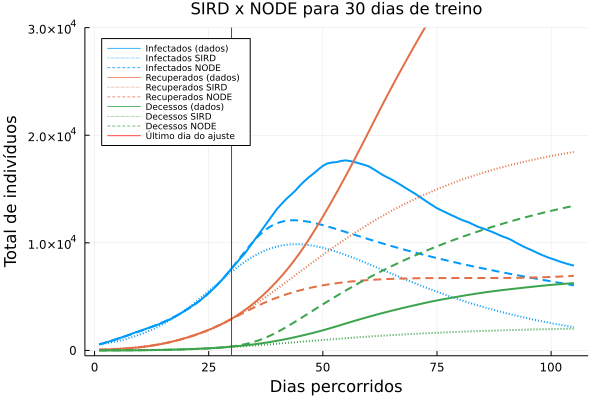

Iteracao : 150 , Erro : 3.34e-4
Inicializando NN:
Iteracao : 100 , Erro : 1.00e-1
Iteracao : 200 , Erro : 2.45e-2
Iteracao : 300 , Erro : 8.45e-3
Iteracao : 400 , Erro : 4.31e-3
Iteracao : 500 , Erro : 2.75e-3
Iteracao : 600 , Erro : 2.13e-3
Iteracao : 700 , Erro : 1.61e-3
Iteracao : 800 , Erro : 1.17e-3
Iteracao : 900 , Erro : 9.33e-4
Iteracao : 1000 , Erro : 8.07e-4
Ajustando NODE:
Iteracao : 10 , Erro : 6.15e-3
Iteracao : 20 , Erro : 1.75e-3
Iteracao : 30 , Erro : 1.60e-3
Iteracao : 40 , Erro : 1.44e-3
Iteracao : 50 , Erro : 1.23e-3
Iteracao : 60 , Erro : 1.10e-3
Iteracao : 70 , Erro : 1.02e-3
Iteracao : 80 , Erro : 9.96e-4
Iteracao : 90 , Erro : 9.93e-4
Iteracao : 100 , Erro : 9.43e-4
Iteracao : 110 , Erro : 9.26e-4
Iteracao : 120 , Erro : 9.23e-4
Iteracao : 130 , Erro : 9.00e-4
Iteracao : 140 , Erro : 8.74e-4


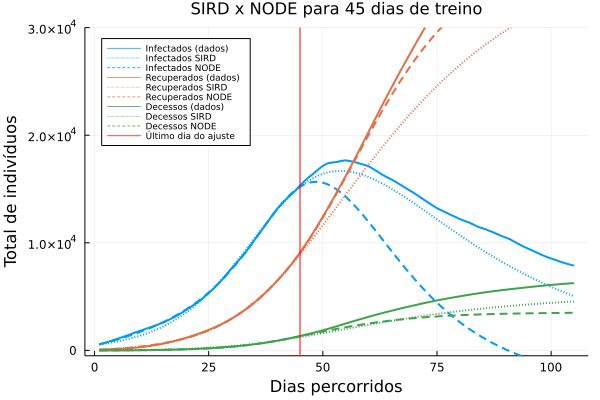

Iteracao : 150 , Erro : 8.46e-4
Inicializando NN:
Iteracao : 100 , Erro : 8.93e-2
Iteracao : 200 , Erro : 4.65e-2
Iteracao : 300 , Erro : 1.94e-2
Iteracao : 400 , Erro : 7.35e-3
Iteracao : 500 , Erro : 3.71e-3
Iteracao : 600 , Erro : 2.79e-3
Iteracao : 700 , Erro : 1.92e-3
Iteracao : 800 , Erro : 1.43e-3
Iteracao : 900 , Erro : 1.17e-3
Iteracao : 1000 , Erro : 9.89e-4
Ajustando NODE:
Iteracao : 10 , Erro : 1.37e-2
Iteracao : 20 , Erro : 2.87e-3
Iteracao : 30 , Erro : 2.22e-3
Iteracao : 40 , Erro : 1.99e-3
Iteracao : 50 , Erro : 1.93e-3
Iteracao : 60 , Erro : 1.78e-3
Iteracao : 70 , Erro : 1.77e-3
Iteracao : 80 , Erro : 1.63e-3
Iteracao : 90 , Erro : 1.57e-3
Iteracao : 100 , Erro : 1.54e-3
Iteracao : 110 , Erro : 1.54e-3
Iteracao : 120 , Erro : 1.48e-3
Iteracao : 130 , Erro : 1.46e-3
Iteracao : 140 , Erro : 1.45e-3


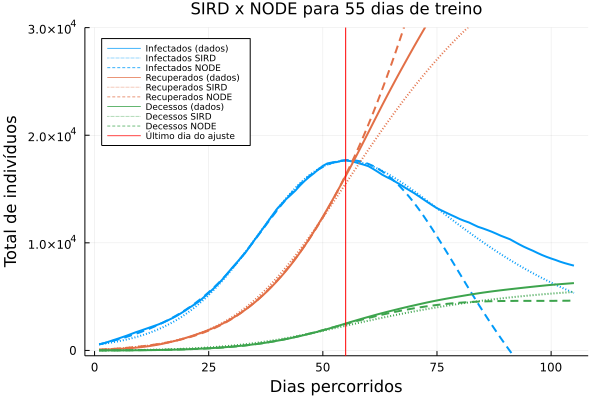

Iteracao : 150 , Erro : 1.41e-3
Inicializando NN:
Iteracao : 100 , Erro : 5.22e-2
Iteracao : 200 , Erro : 2.92e-2
Iteracao : 300 , Erro : 2.46e-2
Iteracao : 400 , Erro : 2.16e-2
Iteracao : 500 , Erro : 1.92e-2
Iteracao : 600 , Erro : 1.79e-2
Iteracao : 700 , Erro : 1.67e-2
Iteracao : 800 , Erro : 1.49e-2
Iteracao : 900 , Erro : 4.83e-3
Iteracao : 1000 , Erro : 4.60e-3
Ajustando NODE:
Iteracao : 10 , Erro : 2.77e-1
Iteracao : 20 , Erro : 1.04e-1
Iteracao : 30 , Erro : 3.89e-2
Iteracao : 40 , Erro : 1.98e-2
Iteracao : 50 , Erro : 1.44e-2
Iteracao : 60 , Erro : 4.07e-3
Iteracao : 70 , Erro : 2.93e-3
Iteracao : 80 , Erro : 1.55e-3
Iteracao : 90 , Erro : 1.39e-3
Iteracao : 100 , Erro : 1.10e-3
Iteracao : 110 , Erro : 1.09e-3
Iteracao : 120 , Erro : 1.06e-3
Iteracao : 130 , Erro : 1.03e-3
Iteracao : 140 , Erro : 1.02e-3


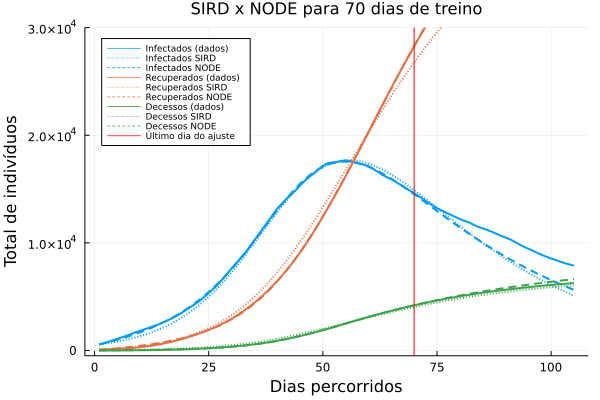

Iteracao : 150 , Erro : 1.02e-3


In [10]:
for N in [20, 30, 45, 55, 70]
    S₀_SIRD, θ₁_SIRD, S₀_NODE, θ₁_NODE = treinarPorN_dias(N, iterSIRD = 10^5, iterBFGS_NODE = 150)
    pl = grafico(N, S₀_SIRD, θ₁_SIRD, S₀_NODE, θ₁_NODE); display(pl)
end